# 6. Evaluating and experimenting with the fine-tuned classifier

This notebook includes some of the tests we did with the logistic classifier that we trained on OpenCLIP image embeddings. Alongside evaluating the Mean Absolute Error (MAE) of the model, we explored the differences in MAE between the various scenes. As reported in the paper, this analysis proved to be inconclusive at this stage, given large differences in the within-scene error rates.

In [ ]:
from google.colab import drive

import pickle
import json
import math
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from sklearn.metrics import accuracy_score, confusion_matrix, mean_absolute_error

In [ ]:
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


## Load data

In [ ]:
# helpers to load and save pickle and json files

def loadPKL(path):
  infile = open(path,'rb')
  X = pickle.load(infile)
  print('Loaded ' + path.split('/')[-1])
  return X

def savePKL(data, path):
  with open(path, 'wb') as f:
    pickle.dump(data, f)
  print('Saved ' + path.split('/')[-1])

def loadJSON(path):
  infile = open(path,'rb')
  X = json.load(infile)
  print('Loaded ' + path.split('/')[-1])
  return X

def saveJSON(data, path):
  with open(path, 'w') as jsonfile:
    json.dump(data, jsonfile)
  print('Saved ' + path.split('/')[-1])

In [ ]:
root_dir = '/content/drive/MyDrive/dating-images'
data_folder = root_dir + '/data/'
model_folder = root_dir + '/models/'
fig_folder = root_dir + '/figures/'

In [ ]:
image_data = loadJSON(data_folder + 'image_data.json')
embeddings = loadPKL(data_folder + 'embeddings.pkl')
embeddings_colorized = loadPKL(data_folder + 'embeddings_colorized.pkl')

Loaded image_data.json
Loaded embeddings.pkl
Loaded embeddings_colorized.pkl


In [ ]:
# image_data = [[path, data, year, scene, train/test], ... ]
years = list(zip(*image_data))[2]
scenes = list(zip(*image_data))[3]

print(years[:10])
print(scenes[:10])

## Split data into train/test sets

In [ ]:
# image_data = [[path, data, year, scene, train/test], ... ]

def split_train_test_sets(image_data, list_to_split):
  train = []
  test = []
  for i, item in enumerate(image_data):
    if item[-1]=='train':
      train.append(list_to_split[i])
      continue
    if item[-1]=='test':
      test.append(list_to_split[i])
      continue
    else:
      print("train/test set not assigned for image index " + str(i)) # this shouldn't happen
  return train, test

In [ ]:
X_train, X_test = split_train_test_sets(image_data, embeddings)
X_colorized_train, X_colorized_test = split_train_test_sets(image_data, embeddings_colorized)

years_train, years_test = split_train_test_sets(image_data, years)
scenes_train, scenes_test = split_train_test_sets(image_data, scenes)

## Load trained models

In [ ]:
classifier = loadPKL(model_folder + '20230621-1014_logistic_year.pkl')
classifier_colorized = loadPKL(model_folder + '20230621-1033_logistic_year_colorized.pkl')

Loaded 20230621-1014_logistic_year.pkl
Loaded 20230621-1033_logistic_year_colorized.pkl


### Classifier accuracy

Trained and evaluated on the original grey-scale photographs.

In [ ]:
years_pred = classifier.predict(X_test)
score = accuracy_score(years_test, years_pred)
print(score)

0.13719588663155255


Trained and evaluated on the colorized photographs.

In [ ]:
years_colorized_pred = classifier_colorized.predict(X_colorized_test)
score_colorized = accuracy_score(years_test, years_colorized_pred)
print(score_colorized)

0.13355906696764486


## Mean Absolute Error

In [ ]:
print(mean_absolute_error(years_test, years_pred))

6.646476047153248


In [ ]:
print(mean_absolute_error(years_test, years_colorized_pred)) # for colorized photographs

6.794958615500376


## Error

In [ ]:
df = pd.DataFrame({"year": years_test, "predicted_year": years_pred, "error_bw": (years_test-years_pred), "error_colorized": (years_test-years_colorized_pred), "absolute_error": abs(years_test-years_pred), "scene": scenes_test})
df

,year,predicted_year,error_bw,error_colorized,absolute_error,scene
0,1954,1957,-3,2,3,group_portrait
1,1991,1984,7,7,7,group_portrait
2,1972,1970,2,2,2,soccer
3,1986,1988,-2,0,2,saint_niclaus
4,1984,1990,-6,-1,6,playground
...,...,...,...,...,...,...
7969,1968,1971,-3,-3,3,welcome_goodbye
7970,1978,1975,3,-7,3,building
7971,1975,1990,-15,-11,15,animals_misc
7972,1989,1986,3,0,3,dancing


### Plot histogram of errors for gray-scale and color predictions

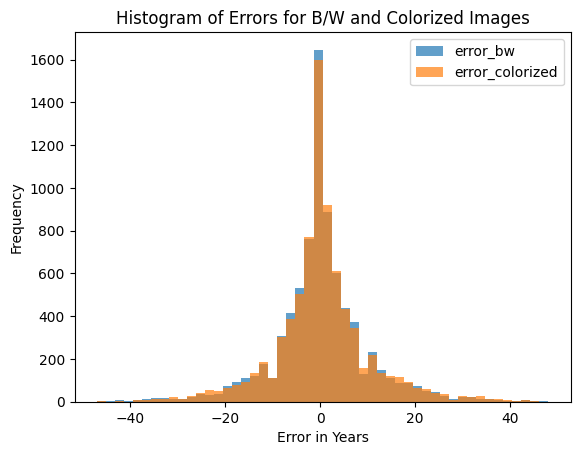

In [ ]:
ax = df[['error_bw', 'error_colorized']].plot.hist(alpha=0.7, bins=50)

ax.set_xlabel('Error in Years')
ax.set_ylabel('Frequency')
ax.set_title('Histogram of Errors for B/W and Colorized Images')


plt.savefig(fig_folder + 'fine_tuned_histogram.png', bbox_inches='tight', dpi=300)
plt.show()

In [ ]:
from scipy import stats
# Perform the two-sample K-S test
ks_statistic, p_value = stats.ks_2samp(df['error_bw'], df['error_colorized'])

print('K-S statistic:', ks_statistic)
print('p-value:', p_value)

K-S statistic: 0.008778530223225483
p-value: 0.9184591646949297


## MAE across scenes - gray-scale

In [ ]:
# make a list of scenes occuring 25 or more times in the dataset to use as a filter

high_freq_scenes = []

for scene in set(scenes):
  if scenes.count(scene) >= 25:
    high_freq_scenes.append(scene)
  else:
    print(scene)
    print(scenes.count(scene))

print(len(high_freq_scenes))

casino
14
windsurfing
13
board_game
3
boxing
17
landfill
23
playing_cards
21
133


In [ ]:
df_test = pd.DataFrame({"year":years_test, "predicted_year":years_pred, "absolute_error": abs(years_test-years_pred), "scene": scenes_test })

In [ ]:
df_train = pd.DataFrame({"year": years_train, "scene":scenes_train })

In [ ]:
# from training data
scene_frequencies = df_train.groupby('scene').count()
min_years = df_train.groupby('scene').min()[['year']]
max_years = df_train.groupby('scene').max()[['year']]
mean_train_years = df_train.groupby('scene').mean()[['year']]

# from predictions on test data
test_means = df_test.groupby('scene').mean()[['absolute_error', 'year']]
std_errors = df_test.groupby('scene')['absolute_error'].std(ddof=0)

df_scenes = pd.DataFrame()

df_scenes['frequency_train'] = scene_frequencies
df_scenes['min_year_train'] = min_years
df_scenes['max_year_train'] = max_years

df_scenes['mean_absolute_error_test'] = test_means['absolute_error']
df_scenes['std'] = std_errors

df_scenes.filter(items=high_freq_scenes, axis=0).sort_values('mean_absolute_error_test').round(2)

,frequency_train,min_year_train,max_year_train,mean_absolute_error_test,std
scene,,,,,
cow,48,1951,1999,2.43,2.13
billiards,30,1951,1999,3.43,3.06
road_biking,151,1954,1999,3.55,4.07
golf,67,1955,1998,4.27,2.59
swan,30,1951,1999,4.40,4.32
...,...,...,...,...,...
amphitheater,45,1950,1999,10.71,13.68
table_tennis,67,1953,1998,10.90,7.63
excavation,34,1950,1997,13.78,10.93


## MAE across scenes - colorized

In [ ]:
df_test = pd.DataFrame({"year":years_test, "predicted_year":years_colorized_pred, "absolute_error": abs(years_test-years_colorized_pred), "scene": scenes_test })

In [ ]:
df_train = pd.DataFrame({"year": years_train, "scene":scenes_train })

In [ ]:
# from training data
scene_frequencies = df_train.groupby('scene').count()
min_years = df_train.groupby('scene').min()[['year']]
max_years = df_train.groupby('scene').max()[['year']]
mean_train_years = df_train.groupby('scene').mean()[['year']]

# from predictions on test data
test_means = df_test.groupby('scene').mean()[['absolute_error', 'year']]
std_errors = df_test.groupby('scene')['absolute_error'].std(ddof=0)

df_scenes = pd.DataFrame()

df_scenes['frequency_train'] = scene_frequencies
df_scenes['min_year_train'] = min_years
df_scenes['max_year_train'] = max_years

df_scenes['mean_absolute_error_test'] = test_means['absolute_error']
df_scenes['std'] = std_errors


df_scenes.filter(items=high_freq_scenes, axis=0).sort_values('mean_absolute_error_test').round(2)

,frequency_train,min_year_train,max_year_train,mean_year_train,mean_year_test,mean_absolute_error_test,std
scene,,,,,,,
swan,30,1951,1999,1982.43,1970.20,2.80,2.64
tram,42,1950,1999,1967.95,1976.25,3.00,2.12
road_biking,151,1954,1999,1980.15,1980.07,3.21,2.76
accident_stretcher,22,1965,1998,1981.18,1973.20,3.40,3.80
soapbox_race,37,1950,1996,1963.97,1962.67,3.67,2.87
...,...,...,...,...,...,...,...
windmill,45,1950,1998,1977.47,1971.79,11.57,6.62
rowing,36,1950,1999,1981.44,1979.77,11.77,12.52
marial_arts,53,1953,1999,1980.28,1981.09,12.36,8.18


## Shifts

For some images colorization had a large impact on error (increasing or decreasing the absolute error), while for others the date predictions remained similar across the two image versions. Here we examined these shifts in error across the scenes.

In [ ]:
df_s = pd.DataFrame({"scene": scenes_test, "error_grayscale":abs(years_test-years_pred), "error_colorized": abs(years_test-years_colorized_pred)})
df_shifts = df_s.groupby('scene').mean()[['error_grayscale', 'error_colorized' ]]
df_shifts['shift'] = df_shifts['error_colorized'] - df_shifts['error_grayscale']
df_shifts.filter(items=high_freq_scenes, axis=0).sort_values('shift').round(2)

,error_grayscale,error_colorized,shift
scene,,,
excavation,13.78,6.78,-7.00
soapbox_race,9.33,3.67,-5.67
buiten_zwembad,14.00,8.50,-5.50
tram,7.25,3.00,-4.25
accident_stretcher,7.60,3.40,-4.20
...,...,...,...
motorcycle,4.89,9.58,4.68
rowing,6.92,11.77,4.85
marial_arts,6.27,12.36,6.09
